In [12]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import gzip
import copy
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import udf
from pyspark.sql.types import LongType
from pyspark.sql.functions import split

In [13]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext

# Import the datasets 

**Instacart datasets** (provided) : https://www.instacart.com/datasets/grocery-shopping-2017 . After loading the datasets, we verified if there were any missing values

In [14]:
products = pd.read_csv('data/products.csv', sep=',')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [15]:
products.isnull().values.any()

False

In [16]:
aisles = pd.read_csv('data/aisles.csv', sep=',')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [17]:
aisles.isnull().values.any()

False

In [18]:
departments = pd.read_csv('data/departments.csv', sep=',')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [19]:
departments.isnull().values.any()

False

In [20]:
orders = pd.read_csv('data/orders.csv', sep=',')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [21]:
orders.isnull().values.sum()==orders['days_since_prior_order'].isnull().values.sum()

True

The missing values in _orders_ correspond to the date of "previous order", when it happens to be the first one.

In [22]:
history = pd.read_csv('data/order_products__prior.csv', sep=',')
history.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [23]:
history.isnull().values.any()

False

There are no unexpected missing values in any of the Instacart datasets.

**Create a dataset with all useful information gathered : products_litteral**

Add the names of the aisle and department in the _products_ dataset, instead of the ID, by merging the datasets :

In [24]:
products_litteral = pd.merge(pd.merge(products, aisles, on='aisle_id'), departments, on='department_id').drop(['aisle_id', 'department_id'], axis=1)
products_litteral.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


**Remove 'missing' values**

In [31]:
missing = products_litteral[(products_litteral.department =='missing') | (products_litteral.aisle=='missing')]
missing.head(50)

,product_id,product_name,aisle,department
42813,38,Ultra Antibacterial Dish Liquid,missing,missing
42814,72,Organic Honeycrisp Apples,missing,missing
42815,110,Uncured Turkey Bologna,missing,missing
42816,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",missing,missing
42817,417,Classics Baby Binks Easter Chocolate Bunny,missing,missing


We can see many products don't have any name for the aisle and/or department

In [32]:
print("There are %d products with 'missing' aisle/department. This represent %0.1f%% of the products." %(missing.shape[0], missing.shape[0]/products_litteral.shape[0]*100))

There are 1258 products with 'missing' aisle/department. This represent 2.5% of the products.


The unlabelled products seem to come from many different categories, and represent a small fraction of our dataset. We decided to simply remove them.

In [36]:
products_litteral = products_litteral.drop(missing.index)

# First Statistical analysis

**Number of products per Aisle and Department**

Visualize the products per aisle and per department to detect any inconsistency

In [50]:
per_dpt=products_litteral[['product_id', 'department']].groupby('department').count().sort_values(by='product_id', ascending=False)

Text(0, 0.5, 'Departments')

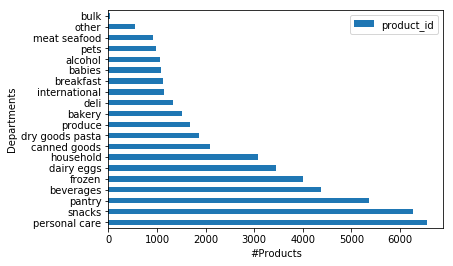

In [51]:
ax = per_dpt.plot(kind='barh')
ax.set_xlabel('#Products')
ax.set_ylabel('Departments')

In [52]:
per_dpt.head()

,product_id
department,
personal care,6563
snacks,6264
pantry,5371
beverages,4365
frozen,4007


The 'personal care' department has the most choice of products, jsut followed by the 'snacks' one.

In [47]:
per_aisle=products_litteral[['product_id', 'aisle']].groupby('aisle').count().sort_values(by='product_id', ascending=False)

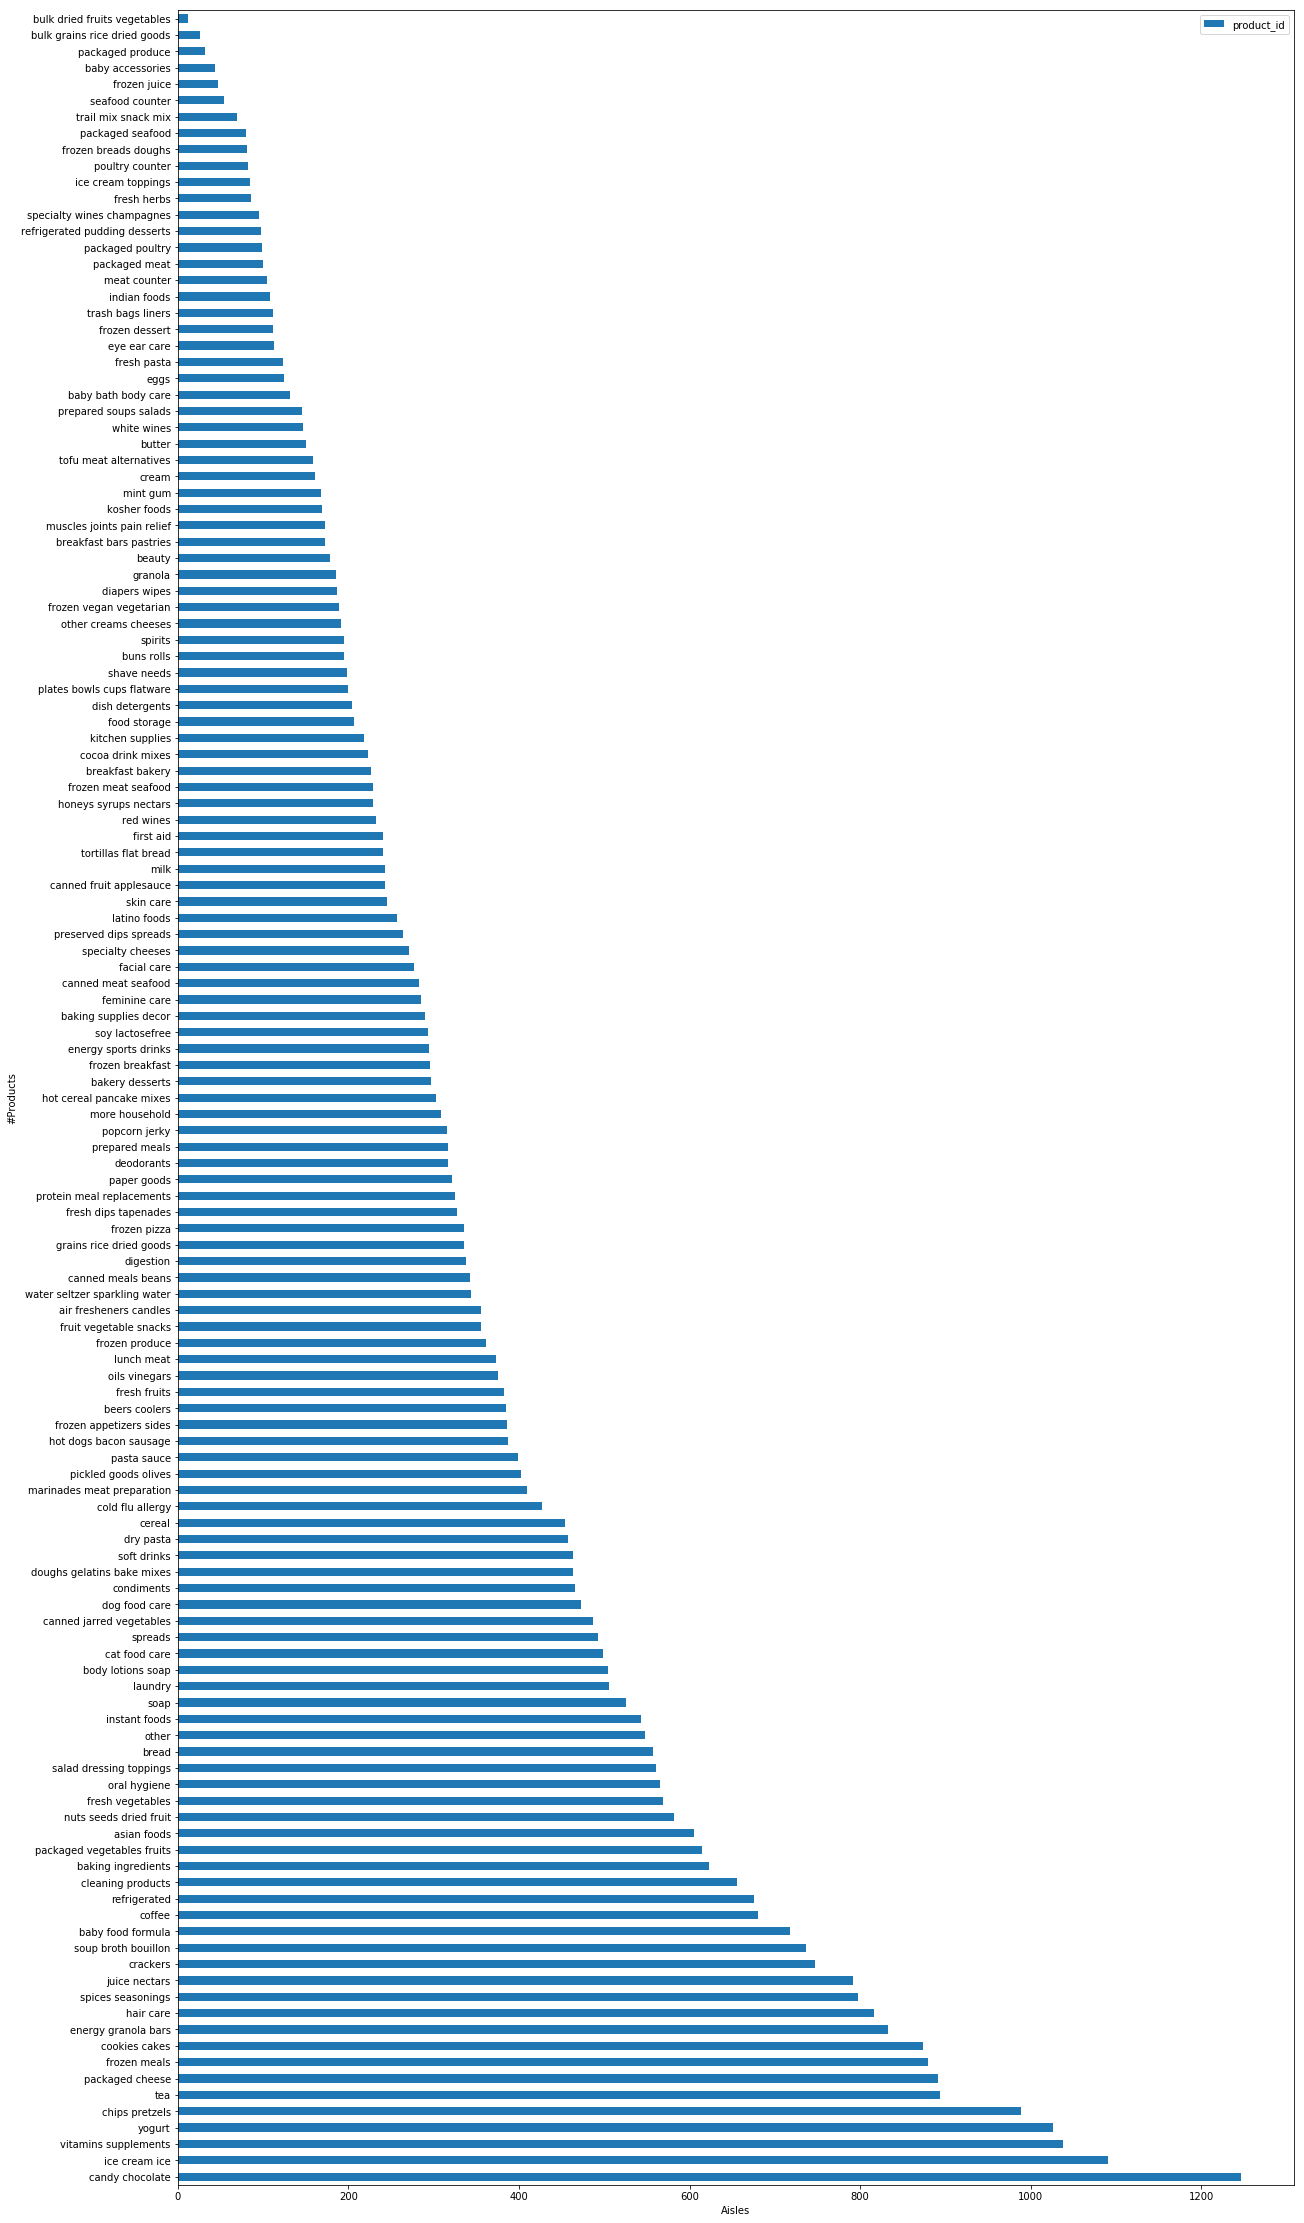

In [48]:
ax = per_aisle.plot(kind='barh', figsize=(20,40))
ax.set_ylabel('#Products')
ax.set_xlabel('Aisles')
plt.show()

In [49]:
per_aisle.head()

,product_id
aisle,
candy chocolate,1246
ice cream ice,1091
vitamins supplements,1038
yogurt,1026
chips pretzels,989


'Candy chocolate' and 'ice cream ice' contains the most numerous choice of products. We can see none of the 10 first aisles is in the 'Personal care' departement. Thus this department contains the most products because it contains a diverse choice of aisles of products, not one aisle with many products, as 'Snacks'.

**Number of orders**

Let's complete our 'useful' dataset with the informtion about the number of orders per product

In [63]:
number_of_order_per_product = history[['order_id','product_id']].groupby('product_id').count().sort_values(by='order_id', ascending=False)
number_of_order_per_product = number_of_order_per_product.rename(columns={"order_id" : "number_of_orders"})
number_of_order_per_product.head()

,number_of_orders
product_id,
24852,472565
13176,379450
21137,264683
21903,241921
47209,213584


In [64]:
products_litteral = pd.merge(products, number_of_order_per_product, on='product_id')
products_litteral.head()

,product_id,product_name,aisle_id,department_id,number_of_orders
0,1,Chocolate Sandwich Cookies,61,19,1852
1,2,All-Seasons Salt,104,13,90
2,3,Robust Golden Unsweetened Oolong Tea,94,7,277
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329
4,5,Green Chile Anytime Sauce,5,13,15


**Number of orders per product**

In [66]:
products_litteral.sort_values(by='number_of_orders', ascending=False).head()

,product_id,product_name,aisle_id,department_id,number_of_orders
24848,24852,Banana,24,4,472565
13172,13176,Bag of Organic Bananas,24,4,379450
21133,21137,Organic Strawberries,24,4,264683
21899,21903,Organic Baby Spinach,123,4,241921
47198,47209,Organic Hass Avocado,24,4,213584


# Try on Amazon dataset

**Amazon dataset** : _metadata_ and _reviews_ of Grocery and Gourmet Food products : https://cseweb.ucsd.edu/~jmcauley/datasets.html?fbclid=IwAR39s5O83nqUYkRBD4jol3OFu0FmcH-4dCzUtSjutOsmSd9LMZOHSGGtNxw#amazon_reviews


In [20]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [21]:
Amazon_meta = spark.read.json("data/meta_Grocery_and_Gourmet_Food.json.gz")
Amazon_meta.take(2)

[Row(also_buy=None, also_view=['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B00H9OX598', 'B001LM42GY', 'B001LM5TDY'], asin='0681727810', brand='Ariola Imports', category=['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda'], date=None, description=['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.'], details=None, feature=None, fit=None, image=None, main_cat='Grocery', price='$41.91', rank='165,181inGroceryGourmetFood(', similar_item=None, tech1=None, title='Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs'),
 Row(also_buy=['B01898YHXK', 'B01BCM6LAC', 'B00Q4OL47O', 'B00Q4OL5QE', '0804189986', 'B00Q4OL2F8', '1101902663', 'B019PDEUU8', 'B01AC97ONO', 'B01LZIS4VX', 'B019QN2DN8', 'B019PDYP7Q', '1101902639', 'B00Q4OL0S2', 'B019PHEIVA', 'B019QNGPSW', 'B0041RGD0E', '0998089508', '0988775115', 'B0006Z7NNG', 'B00MU73UKS', 

In [22]:
Amazon_meta_light = Amazon_meta.drop('also_view','description','details','feature','fit', 'image','similar_item', 'tech1')

In [17]:
Amazon_meta_light.printSchema()

root
 |-- also_buy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: string (nullable = true)
 |-- main_cat: string (nullable = true)
 |-- price: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- title: string (nullable = true)



In [23]:
Amazon_reviews = spark.read.json("data/Grocery_and_Gourmet_Food.json.gz")
Amazon_reviews.take(2)

[Row(asin='1888861614', image=None, overall=5.0, reviewText='Very pleased with my purchase. Looks exactly like the picture and will look great on my cake. It definitely will sparkle.', reviewTime='06 4, 2013', reviewerID='ALP49FBWT4I7V', reviewerName='Lori', style=None, summary='Love it', unixReviewTime=1370304000, verified=True, vote=None),
 Row(asin='1888861614', image=None, overall=4.0, reviewText='Very nicely crafted but too small. Am going to have to add some flowers or something to compensate for the size.', reviewTime='05 23, 2014', reviewerID='A1KPIZOCLB9FZ8', reviewerName='BK Shopper', style=None, summary='Nice but small', unixReviewTime=1400803200, verified=True, vote=None)]

In [51]:
Amazon_reviews.printSchema()

root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Design:: string (nullable = true)
 |    |-- Display Height:: string (nullable = true)
 |    |-- Edition:: string (nullable = true)
 |    |-- Flavor Name:: string (nullable = true)
 |    |-- Flavor:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Item Display Weight:: string (nullable = true)
 |    |-- Item Package Quantity:: string (nullable = true)
 |    |-- Material Type:: string (nullable = true)
 |    |-- Material:: string (nullable = true)
 |    |-- Number of Items:: string (nullable = true)
 |    |-- Package Quantity:: string (nulla

In [44]:
products_litteral.head(10)

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks
5,331,Organic Lemon Gingersnap,cookies cakes,snacks
6,449,Chips Ahoy! Chewy Cookies,cookies cakes,snacks
7,559,Cookie Chips Crunchy Dark Chocolate Chocolate ...,cookies cakes,snacks
8,569,Golden Cupcakes 8 Pack,cookies cakes,snacks
9,574,Crunch Vanilla Sugar Mini Cookies,cookies cakes,snacks


In [35]:
Amazon_meta.select(Amazon_meta.category).take(20)

[Row(category=['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda']),
 Row(category=['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol']),
 Row(category=['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']),
 Row(category=['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']),
 Row(category=['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']),
 Row(category=['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']),
 Row(category=['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Toppers']),
 Row(category=['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers', 'Cake Top

**Connect the two datasets**

Use only a sample of the all Amazon datasets for the tests

In [233]:
Amazon1=Amazon_meta_light.sample(False, 0.0001)

In [202]:
Amazon1.count() #number of rows in this test sample Amazon dataset

273

In [25]:
products_lit_spark = spark.createDataFrame(products_litteral) #convert Instacart panda df to spark df

In [31]:
products_lit_spark.count()

49688

**first try** Try to join by the name of the products 

In [33]:
df = Amazon1.join(products_lit_spark, col('title')== col('product_name'))

In [34]:
df.count()

2

Not working, never more than a few fits (1 or 2) over the 2876 Amazon reviews and 49688 Instacart products

**second try** Try to join on : if Instacart name is in the Amazon title

In [102]:
df = Amazon1.join(products_lit_spark, col('title').contains(col('product_name')))

In [104]:
df.take(10)

[Row(also_buy=None, asin='B0018R0RI4', brand='Big Hunk', category=['Grocery & Gourmet Food', 'Candy & Chocolate'], date=None, main_cat='Grocery', price=None, rank='1,387,093inGroceryGourmetFood(', title="Annabelle's Big Hunk Mini Morsels, Terrific Chewy Nougat with Peanuts, 3.8-Ounce Boxes (Pack of 12)", product_id=12490, product_name='Mini', aisle='cookies cakes', department='snacks'),
 Row(also_buy=None, asin='B0060YGD9M', brand='Necco', category=['Grocery & Gourmet Food', 'Candy & Chocolate', 'Mints'], date=None, main_cat='Grocery', price=None, rank='398,343inGroceryGourmetFood(', title='Mini Rolls of Necco Wafers x10', product_id=12490, product_name='Mini', aisle='cookies cakes', department='snacks'),
 Row(also_buy=None, asin='B00R92ZTOE', brand=None, category=['Grocery & Gourmet Food', 'Candy & Chocolate', 'Candied & Chocolate-covered Snacks'], date=None, main_cat='Grocery', price='$34.15', rank='868,423inGroceryGourmetFood(', title="Demet's Turtles Brand Caramel Nut Clusters Mini

It is impossible to link by name because actually, the Instacart dataset doesn't reference precise products but generic names (no brands)

In [105]:
df.count()

557

There are too many lines : as the Instacart title is not specific enough, it links many Amazon product

In [109]:
df.dropDuplicates(['title']).take(2)

[Row(also_buy=['B01FULLSG8', 'B01F7F3DRE'], asin='B01F5Y1NRY', brand="Miss Anna's", category=['Grocery & Gourmet Food', 'Sauces, Gravies & Marinades', 'Hot Sauce'], date=None, main_cat='Grocery', price='$21.95', rank='212,557inGroceryGourmetFood(', title="Miss Anna's Hot Pepper Sauce - 2 PACK - Shipping Included", product_id=42499, product_name='Sauce', aisle='condiments', department='pantry'),
 Row(also_buy=None, asin='B001ECIWSK', brand='Hallmark', category=['Grocery & Gourmet Food', 'Cooking & Baking', 'Frosting, Icing & Decorations', 'Cake & Cupcake Toppers'], date=None, main_cat='Toys & Games', price=None, rank='>#3,307,813 in Toys & Games (See Top 100 in Toys & Games)>#68,458 in Home & Kitchen > Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers', title='Barbie Ballerina White', product_id=19567, product_name='White', aisle='specialty cheeses', department='dairy eggs')]

In [107]:
df.dropDuplicates(['title']).count()

228

Weird associations (still because of the non specific Instacart title). I think that is because I have a little Amazon sample, otherwise it would just drop almost every row

**Third try** : only join the categories 

In [234]:
Amazon1 = Amazon1.select('title','category')

In [235]:
Amazon1=Amazon1.select('title', explode('category').alias('category'))

In [205]:
Amazon1.take(5)

[Row(title='Calorie Control Whipped Topping Mix', category='Grocery & Gourmet Food'),
 Row(title='Calorie Control Whipped Topping Mix', category='Cooking & Baking'),
 Row(title='Calorie Control Whipped Topping Mix', category='Pudding & Gelatin'),
 Row(title='Calorie Control Whipped Topping Mix', category='Pudding'),
 Row(title='ROLO Chewy Caramels in Milk Chocolate – Kids Favorite Candy (1.7-Oz / Pack of 36)', category='Grocery & Gourmet Food')]

In [206]:
df = Amazon1.join(products_lit_spark, products_lit_spark.aisle==Amazon1.category)

In [207]:
df.count()

0

Not the same exact names of categories, so nto working

**fourth try** : joindre les categories Amazon et les aisles Instacart avec des mots en commun

In [222]:
#separate Instacart aisle name, because names are too specific (to match cookies cakes with snack cakes for instance)
split_col = split(products_lit_spark['aisle'], ' ')
split_aisle = products_lit_spark.withColumn('aisle1', split_col.getItem(0))
split_aisle = split_aisle.withColumn('aisle2', split_col.getItem(1))
split_aisle.show()

+----------+--------------------+-------------+----------+-------+------+
|product_id|        product_name|        aisle|department| aisle1|aisle2|
+----------+--------------------+-------------+----------+-------+------+
|         1|Chocolate Sandwic...|cookies cakes|    snacks|cookies| cakes|
|        78|Nutter Butter Coo...|cookies cakes|    snacks|cookies| cakes|
|       102|Danish Butter Coo...|cookies cakes|    snacks|cookies| cakes|
|       172|Gluten Free All N...|cookies cakes|    snacks|cookies| cakes|
|       285|Mini Nilla Wafers...|cookies cakes|    snacks|cookies| cakes|
|       331|Organic Lemon Gin...|cookies cakes|    snacks|cookies| cakes|
|       449|Chips Ahoy! Chewy...|cookies cakes|    snacks|cookies| cakes|
|       559|Cookie Chips Crun...|cookies cakes|    snacks|cookies| cakes|
|       569|Golden Cupcakes 8...|cookies cakes|    snacks|cookies| cakes|
|       574|Crunch Vanilla Su...|cookies cakes|    snacks|cookies| cakes|
|       576|Vanilla Sugar Coo...|cooki

In [224]:
#see if aisle words are included in the category name Amazon 
df = Amazon1.select('category').distinct().join(split_aisle.select('aisle1', 'aisle2').distinct(), col('category').contains(col('aisle1')) | col('category').contains(col('aisle2')))

In [225]:
df.take(20)

[Row(category='Dairy, Cheese & Eggs', aisle1='air', aisle2='fresheners'),
 Row(category='Fresh Seafood', aisle1='baby', aisle2='food'),
 Row(category='Meat & Seafood Gifts', aisle1='baby', aisle2='food'),
 Row(category='Meat & Seafood', aisle1='baby', aisle2='food'),
 Row(category='Seafood', aisle1='baby', aisle2='food'),
 Row(category='Meat, Poultry & Seafood', aisle1='baby', aisle2='food'),
 Row(category='Fresh Seafood', aisle1='cat', aisle2='food'),
 Row(category='Meat & Seafood Gifts', aisle1='cat', aisle2='food'),
 Row(category='Meat & Seafood', aisle1='cat', aisle2='food'),
 Row(category='Seafood', aisle1='cat', aisle2='food'),
 Row(category='Meat, Poultry & Seafood', aisle1='cat', aisle2='food'),
 Row(category='Walnuts', aisle1='nuts', aisle2='seeds'),
 Row(category='Peanuts', aisle1='nuts', aisle2='seeds'),
 Row(category='Fresh Seafood', aisle1='food', aisle2='storage'),
 Row(category='Meat & Seafood Gifts', aisle1='food', aisle2='storage'),
 Row(category='Meat & Seafood', aisl

ça ne marche pas du tout : il faut faire matcher les mots entier, pas juste "contains" !

In [236]:
#avec pyspark, necessité de passer par les fonctions python udf
@udf('string')
def mots(l) :
    return re.compile("\\W+").split(l)

In [237]:
Amazon1 = Amazon1.withColumn('mots', mots(Amazon1.category))

In [238]:
Amazon1.take(5)

Py4JJavaError: An error occurred while calling o1770.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 228.0 failed 1 times, most recent failure: Lost task 0.0 in stage 228.0 (TID 4639, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\auria\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 362, in main
  File "C:\Users\auria\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 715, in read_int
    length = stream.read(4)
  File "C:\Users\auria\Anaconda3\lib\socket.py", line 589, in readinto
    return self._sock.recv_into(b)
socket.timeout: timed out

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3263)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3260)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3260)
	at sun.reflect.GeneratedMethodAccessor119.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\auria\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 362, in main
  File "C:\Users\auria\Anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 715, in read_int
    length = stream.read(4)
  File "C:\Users\auria\Anaconda3\lib\socket.py", line 589, in readinto
    return self._sock.recv_into(b)
socket.timeout: timed out

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


_Obviously, this fucntion doesn't work, but why ?? seems like something is "too big"..._